## Airline Booking Demand Forecasting 
## Course: IS-5201-01 Programming For Business Analytics
## Project Type: Group 

### Setting - up 

In [1]:
# Import the required libraries 
import os
import pandas as pd    
import numpy as np 
import statsmodels.formula.api as sm 
import warnings
warnings.filterwarnings('ignore')

## Set working directory
os.chdir("C:/Users/aparn/Desktop/Airline")

### Training Data Set

In [2]:
# Import the training data file
train_dat = pd.read_csv("airline_booking_trainingData.csv", sep=',', header=0)

### EDA with Training Data Set

In [3]:
# Reading the top 10 rows
train_dat.head(10)

,departure_date,booking_date,cum_bookings
0,5/1/2012,3/2/2012,0
1,5/1/2012,3/3/2012,0
2,5/1/2012,3/4/2012,0
3,5/1/2012,3/5/2012,0
4,5/1/2012,3/6/2012,1
5,5/1/2012,3/7/2012,1
6,5/1/2012,3/8/2012,1
7,5/1/2012,3/9/2012,4
8,5/1/2012,3/10/2012,4
9,5/1/2012,3/11/2012,4


In [4]:
# Check the datatype for all columns
train_dat.dtypes

departure_date    object
booking_date      object
cum_bookings       int64
dtype: object

#### We will convert departure_date and booking_date to datetime objects

In [5]:
# Convert the departure_date and booking_date to datetime objects   
train_dat['departure_date'] = pd.to_datetime(train_dat['departure_date'])
train_dat['booking_date'] = pd.to_datetime(train_dat['booking_date'])   

In [6]:
# Check the datatypes for all columns again
train_dat.dtypes

departure_date    datetime64[ns]
booking_date      datetime64[ns]
cum_bookings               int64
dtype: object

#### We will add more columns using existing ones

In [7]:
# Add new column: days_prior  = departure_date - booking_date  
train_dat['days_prior'] = (train_dat['departure_date'] - train_dat['booking_date']).dt.days 

# Add new column: week_day  =  on which day the deparrture date falls   
train_dat['week_day'] = train_dat['departure_date'].dt.weekday_name

# Add new column: final_demand  =  as max(cum_bookings) for a given deparrture date  
train_dat['final_demand'] = train_dat.groupby(['departure_date'], sort=False)['cum_bookings'].transform(max) 

# Add new colum: remaining_demand = final_demand - cum_bookings 
train_dat['remaining_demand'] = train_dat['final_demand'] - train_dat['cum_bookings']

# Historical avg_remaining_demands for each day_prior (into) week_day combination     
train_dat['avg_remaining_demand'] = train_dat.groupby(['days_prior', 'week_day'], sort=False)['remaining_demand'].transform(np.mean)   

# Add new colum: booking_rate = cum_bookings / final_demand  
train_dat['booking_rate'] = train_dat['cum_bookings'] /train_dat['final_demand']

# Historical avg_booking_rates_demands for each day_prior (into) week_day combination     
train_dat['avg_booking_rate_weekday'] = train_dat.groupby(['days_prior', 'week_day'], sort=False)['booking_rate'].transform(np.mean)  

# Historical avg_booking_rates_demands for each day_prior      
train_dat['avg_booking_rate'] = train_dat.groupby(['days_prior'], sort=False)['booking_rate'].transform(np.mean)  

In [8]:
# Check the datatypes for all columns again
train_dat.dtypes

departure_date              datetime64[ns]
booking_date                datetime64[ns]
cum_bookings                         int64
days_prior                           int64
week_day                            object
final_demand                         int64
remaining_demand                     int64
avg_remaining_demand               float64
booking_rate                       float64
avg_booking_rate_weekday           float64
avg_booking_rate                   float64
dtype: object

### Validation Data Set

In [9]:
# Load validation dataset
valid_dat = pd.read_csv("airline_booking_validationData_revised.csv", sep=',', header=0)

In [10]:
# Reading the top 10 rows
valid_dat.head(10)

,departure_date,booking_date,cum_bookings,final_demand,naive_forecast
0,7/25/2012,7/25/2012,300,300,NaN
1,7/25/2012,7/24/2012,255,300,301.046724
2,7/25/2012,7/23/2012,233,300,300.046929
3,7/25/2012,7/22/2012,227,300,313.357631
4,7/25/2012,7/21/2012,223,300,328.106062
5,7/25/2012,7/20/2012,220,300,344.182656
6,7/25/2012,7/19/2012,212,300,353.859101
7,7/25/2012,7/18/2012,200,300,358.397519
8,7/25/2012,7/17/2012,184,300,358.397519
9,7/25/2012,7/16/2012,158,300,358.397519


In [11]:
# Check the datatype for all columns
valid_dat.dtypes

departure_date     object
booking_date       object
cum_bookings        int64
final_demand        int64
naive_forecast    float64
dtype: object

In [12]:
# Convert the departure_date and booking_date to datetime objects   
valid_dat['departure_date'] = pd.to_datetime(valid_dat['departure_date'])
valid_dat['booking_date'] = pd.to_datetime(valid_dat['booking_date'])

#### As in the training dataset, we will make transformation in validation dataset 

In [13]:
# Add new column: days_prior  = departure_date - booking_date   
valid_dat['days_prior'] = (valid_dat['departure_date'] - valid_dat['booking_date']).dt.days 

# Add new column: week_day  =  on which day the deparrture date falls   
valid_dat['week_day'] = valid_dat['departure_date'].dt.weekday_name
    
# No forecasts are required for the actual departure date i.e. on days_prior =0
# Accordingly, we will subset valid_dat to exclude rows with drop days_prior as 0
valid_dat = valid_dat.loc[valid_dat['days_prior'] != 0]    

In [14]:
# Check the datatypes for all columns again
valid_dat.dtypes

departure_date    datetime64[ns]
booking_date      datetime64[ns]
cum_bookings               int64
final_demand               int64
naive_forecast           float64
days_prior                 int64
week_day                  object
dtype: object

#### We define benchmark errors based on naive forecasts in validation data set

In [15]:
# Add new column: benchmark errors which are the errors recorded in the naive forecasts 
valid_dat['benchmark_errors'] = abs(valid_dat['final_demand']-valid_dat['naive_forecast']) 

# Calculate the benchmark_total_errors :
benchmark_total_errors = valid_dat['benchmark_errors'].sum()         

### A: MULTIPLICATIVE MODEL
#### Inputs: days_prior 
##### Formula: Predicted Bookings =  (Cumulative Bookings) / (Average Booking Rate)    

In [16]:
# Generate booking_rates_hist data frame using unique combinations of days_prior and week_day       
booking_rates_hist_a = train_dat.drop_duplicates(subset = ['days_prior'])          
booking_rates_hist_a = booking_rates_hist_a[['days_prior','avg_booking_rate']]   
    
# Using booking_rates_hist to generate predicted_rates for valid_data 
predicted_rates_a = valid_dat.merge(booking_rates_hist_a, how = 'left', on = ['days_prior'])  

# Add new column: robust_forecast   
predicted_rates_a['robust_forecast'] = predicted_rates_a['cum_bookings']/predicted_rates_a['avg_booking_rate']      

# Add new column: robust_errors 
predicted_rates_a['robust_errors'] = abs(predicted_rates_a['final_demand']-predicted_rates_a['robust_forecast'])  

# Reading the top 10 rows
predicted_rates_a.head(5) 

,departure_date,booking_date,cum_bookings,final_demand,naive_forecast,days_prior,week_day,benchmark_errors,avg_booking_rate,robust_forecast,robust_errors
0,2012-07-25,2012-07-24,255,300,301.046724,1,Wednesday,1.046724,0.849335,300.234725,0.234725
1,2012-07-25,2012-07-23,233,300,300.046929,2,Wednesday,0.046929,0.778596,299.256642,0.743358
2,2012-07-25,2012-07-22,227,300,313.357631,3,Wednesday,13.357631,0.727391,312.074220,12.074220
3,2012-07-25,2012-07-21,223,300,328.106062,4,Wednesday,28.106062,0.682387,326.794135,26.794135
4,2012-07-25,2012-07-20,220,300,344.182656,5,Wednesday,44.182656,0.641804,342.783619,42.783619


#### We'll visulaize the data

In [17]:
# plotting the average_booking_rate' by 'days_prior'   
from ggplot import *
ggplot(aes(x = 'days_prior', y = 'avg_booking_rate'), data = predicted_rates_a) +\
   geom_line(color = "steelblue", lw = 2) +\
   theme_bw() +\
   xlab("Days Prior") +\
   ylab("Average Booking Rate") +\
   ggtitle("Average Booking Rates")

<Figure size 1100x800 with 1 Axes>

<ggplot: (-9223371855085146417)>

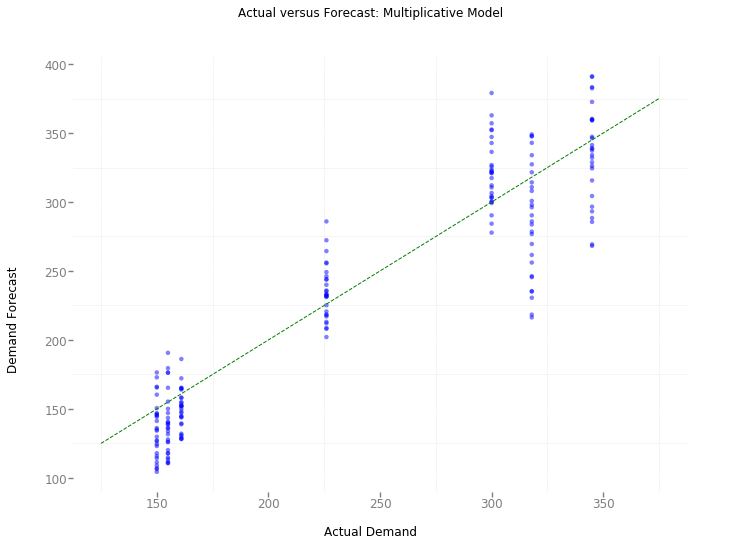

<ggplot: (-9223371855084954687)>

In [18]:
## Plotting the 'robust_forecast' versus 'final_demand'   
from ggplot import *
ggplot(aes(x = 'final_demand', y = 'robust_forecast'), data = predicted_rates_a) +\
 geom_point(color = "blue", size = 20, alpha = 0.5) +\
 geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "green")  +\
 theme_bw() +\
 xlab("Actual Demand") +\
 ylab("Demand Forecast") +\
 ggtitle("Actual versus Forecast: Multiplicative Model")

#### Summary: Multiplicative Model   

In [19]:
# Calculate the robust_total_errors :
robust_total_errors_a = predicted_rates_a['robust_errors'].sum()     
# Calculate MASE : (robust_total_errors)/(benchmark_total_errors)  
mase_a = round((robust_total_errors_a)/(benchmark_total_errors),4)  
improve_a = round((1 - mase_a)*100,2)   
print("\n" + "ESTIMATION_METHOD: multiplicative" + "\n" + \
            "INPUTS: days_prior" +"\n" + "MASE: " + str(mase_a) + "\n" + "IMPROVEMENT OVER BENCHMARK: " + str(improve_a) + "%")


ESTIMATION_METHOD: multiplicative
INPUTS: days_prior
MASE: 0.8298
IMPROVEMENT OVER BENCHMARK: 17.02%


#### Multiplicative model improves the benchmark errors by 17.02%    

### B: ADDITIVE MODEL
#### Inputs: days_prior, week_day 
##### Formula: Predicted Bookings =  (Cumulative Bookings) + (Average Remaining Demand )    

In [20]:
# Generate booking_rates_hist data frame using unique combinations of days_prior and week_day       
booking_rates_hist_b = train_dat.drop_duplicates(subset = ['days_prior', 'week_day'])          
booking_rates_hist_b = booking_rates_hist_b[['days_prior','week_day','avg_remaining_demand']]

# Using booking_rates_hist to generate predicted_rates for valid_data 
predicted_rates_b = valid_dat.merge(booking_rates_hist_b, how = 'left', on = ['days_prior', 'week_day'])

# Add new column: robust_forecast   
predicted_rates_b['robust_forecast'] = predicted_rates_b['cum_bookings'] + predicted_rates_b['avg_remaining_demand']      

# Add new column: robust_errors 
predicted_rates_b['robust_errors'] = abs(predicted_rates_b['final_demand']-predicted_rates_b['robust_forecast'])  

# Reading the top 10 rows
predicted_rates_b.head(5)  

,departure_date,booking_date,cum_bookings,final_demand,naive_forecast,days_prior,week_day,benchmark_errors,avg_remaining_demand,robust_forecast,robust_errors
0,2012-07-25,2012-07-24,255,300,301.046724,1,Wednesday,1.046724,27.833333,282.833333,17.166667
1,2012-07-25,2012-07-23,233,300,300.046929,2,Wednesday,0.046929,49.750000,282.750000,17.250000
2,2012-07-25,2012-07-22,227,300,313.357631,3,Wednesday,13.357631,73.000000,300.000000,0.000000
3,2012-07-25,2012-07-21,223,300,328.106062,4,Wednesday,28.106062,78.833333,301.833333,1.833333
4,2012-07-25,2012-07-20,220,300,344.182656,5,Wednesday,44.182656,83.000000,303.000000,3.000000


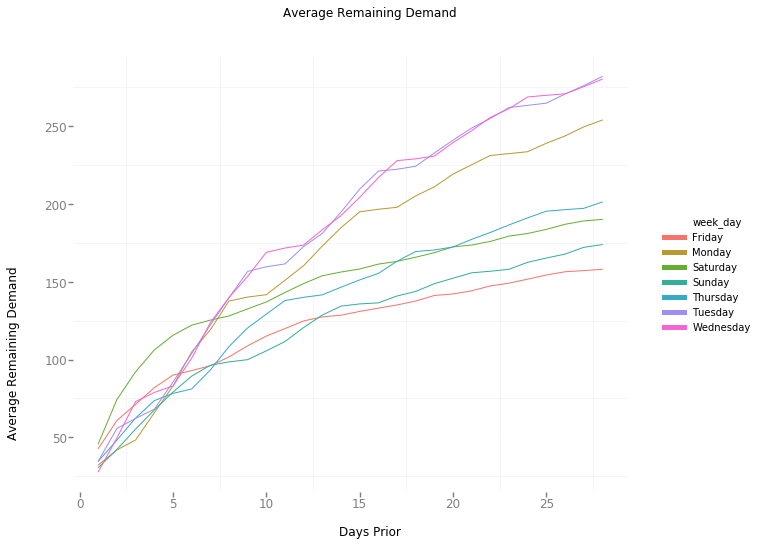

<ggplot: (-9223371855084966498)>

In [21]:
# plotting the 'average_remaining_demand' by 'days_prior'   
from ggplot import *
ggplot(aes(x = 'days_prior', y = 'avg_remaining_demand', color = 'week_day'), data = predicted_rates_b) +\
   geom_line() +\
   theme_bw() +\
   xlab("Days Prior") +\
   ylab("Average Remaining Demand") +\
   ggtitle("Average Remaining Demand")

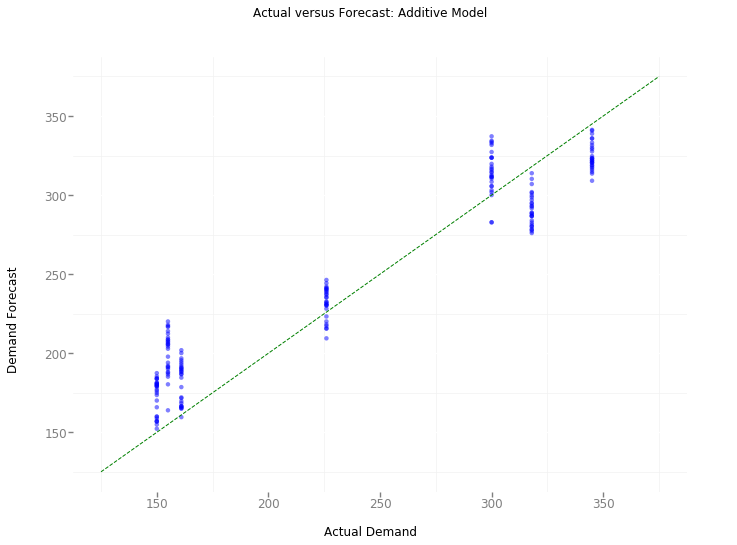

<ggplot: (181769910448)>

In [22]:
## Plotting the 'robust_forecast' versus 'final_demand'   
from ggplot import *
ggplot(aes(x = 'final_demand', y = 'robust_forecast'), data = predicted_rates_b) +\
 geom_point(color = "blue", size = 20, alpha = 0.5) +\
 geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "green")  +\
 theme_bw() +\
 xlab("Actual Demand") +\
 ylab("Demand Forecast") +\
 ggtitle("Actual versus Forecast: Additive Model")

#### Summary: Additive Model

In [23]:
# Calculate the robust_total_errors :
robust_total_errors_b = predicted_rates_b['robust_errors'].sum()     

# Calculate MASE : (robust_total_errors)/(benchmark_total_errors)  
mase_b = round((robust_total_errors_b)/(benchmark_total_errors),4)  
improve_b = round((1 - mase_b)*100,2)   

print("\n" + "ESTIMATION_METHOD: additive" + "\n" + \
            "INPUTS: days_prior" +"\n" + "MASE: " + str(mase_b) + "\n" + "IMPROVEMENT OVER BENCHMARK: " + str(improve_b) + "%")


ESTIMATION_METHOD: additive
INPUTS: days_prior
MASE: 0.7861
IMPROVEMENT OVER BENCHMARK: 21.39%


### C: REGRESSION MODEL
#### Inputs: days_prior, week_day, cum_bookings 
##### Formula: Final Demand  ~  (Days Prior ) + ( Week_Day) + (Cumulative Bookings) 

In [24]:
# Linear regression model      
rates_fit = sm.ols(formula = "final_demand ~ days_prior + week_day + cum_bookings", data = train_dat).fit()

# Add new column: robust_forecast  
predicted_rates_c = pd.DataFrame()
predicted_rates_c = valid_dat
predicted_rates_c['robust_forecast'] = rates_fit.predict(predicted_rates_c) 

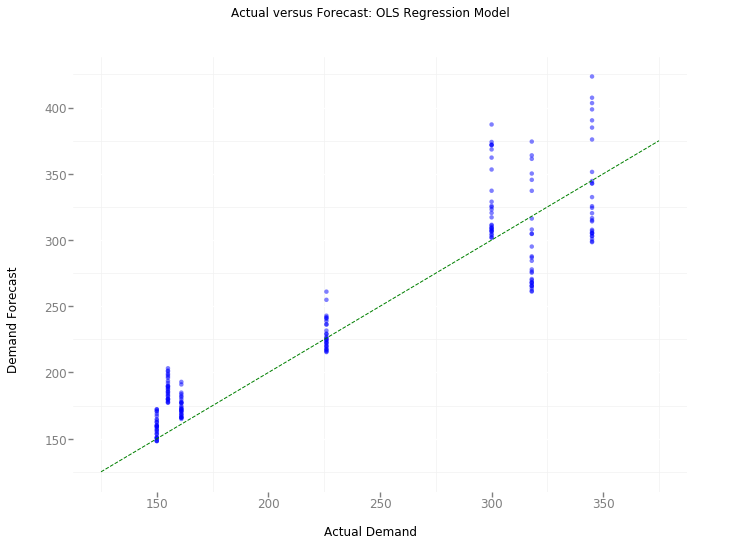

<ggplot: (-9223371855084837253)>

In [25]:
## Plotting the 'robust_forecast' versus 'final_demand'   
from ggplot import *
ggplot(aes(x = 'final_demand', y = 'robust_forecast'), data = predicted_rates_c) +\
 geom_point(color = "blue", size = 20, alpha = 0.5) +\
 geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "green")  +\
 theme_bw() +\
 xlab("Actual Demand") +\
 ylab("Demand Forecast") +\
 ggtitle("Actual versus Forecast: OLS Regression Model")

#### Summary: OLS Regression  Model

In [26]:
# Add new column: robust_errors 
predicted_rates_c['robust_errors'] = abs(predicted_rates_c['final_demand']-predicted_rates_c['robust_forecast'])  

# Calculate the robust_total_errors :
robust_total_errors_c = predicted_rates_c['robust_errors'].sum()     

# Calculate MASE : (robust_total_errors)/(benchmark_total_errors)  
mase_c = round((robust_total_errors_c)/(benchmark_total_errors),4) 
mase_c



# Calculate MASE : (robust_total_errors)/(benchmark_total_errors)  
mase_c = round((robust_total_errors_c)/(benchmark_total_errors),4)  
improve_c = round((1 - mase_c)*100,2)   

print("\n" + "ESTIMATION_METHOD: OLS regression" + "\n" + \
            "INPUTS: days_prior, week_day, cum_bookings" +"\n" + "MASE: " + str(mase_c) + "\n" + "IMPROVEMENT OVER BENCHMARK: " + str(improve_c) + "%")



ESTIMATION_METHOD: OLS regression
INPUTS: days_prior, week_day, cum_bookings
MASE: 0.8042
IMPROVEMENT OVER BENCHMARK: 19.58%
